<a href="https://colab.research.google.com/github/bigluck07/Code_States_Project/blob/main/n223a_evaluation_metrics_for_classification%5B%EC%9D%B4%EB%8C%80%EC%9A%B4%5D_%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 3*

# 📝 Assignment
---

# Evaluation Metrics for Classification

### 1) Kaggle 챌린지를 이어서 진행합니다.
- **다음 조건에서 F beta score를 구하고 과제 제출폼에 제출하세요.**
    - TP = 4442, TN = 6165, FP = 1515, FN = 1930, 재현율에 정밀도의 2배 가중치를 부여합니다. (f-bate-score에서 가중치 줄 수 있음)

In [ ]:
!pip install category_encoders==2.*

accuracy = 𝑇𝑃+𝑇𝑁 / 𝑇𝑃+𝑇𝑁+𝐹𝑃+𝐹𝑁

precision = 𝑇𝑃 / 𝑇𝑃+𝐹𝑃
 
recall = 𝑇𝑃 / 𝑇𝑃+𝐹𝑁

fallout = 𝐹𝑃 / 𝐹𝑃+𝑇𝑁

𝐹𝛽 = ( 1 + 𝛽**2 ) ( precision * recall ) / (( 𝛽**2 * precision ) + recall) 



In [7]:
tp = 4442
tn = 6165
fp = 1515
fn = 1930

beta = 2
#정밀도: 모델이 p로 예측한 경우(tp, fp) 중 진짜 p인 경우
pre_p = tp+fp
precision = tp / pre_p

#재현율: 실제 p(tp, fn) 중에 모델이 P로 예측한 경우
r_p = tp+fn
recall = tp / r_p

# f1 beta점수
f1_beta = (1+beta**2)*((precision*recall)/((beta**2*precision)+recall))

precision, recall, f1_beta

(0.7456773543730065, 0.697112366603892, 0.7063126093178564)

### 데이터 불러오기

In [8]:
import pandas as pd
import numpy as np

In [28]:
# read_data
target = 'vacc_h1n1_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

In [29]:
#EDA 
def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
        
    # 새로운 특성을 생성합니다.
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)
    
    # 거주 구성원 : 어린이 구성원 비율, 어른 구성원 비율 컬럼 생성
    df["proportion_child"] = round((df["household_children"]/df["n_people_r"])*100, 0)
    df["proportion_adult"] = round((df["n_adult_r"]/df["n_people_r"])*100, 0)
 
    # 특성 drop
    features_del = ["employment_industry", "employment_occupation", "n_adult_r", "household_children","census_msa", "state",
                   'doctor_recc_seasonal', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc']
    df.drop(features_del, axis=1, inplace= True)

    return df


train_clear = engineer(train)
test_clear = engineer(test)

In [ ]:
print(train_clear.shape, train_clear.columns)
print('\n')
print(test_clear.shape, test_clear.columns)

In [32]:
# data_split
from sklearn.model_selection import train_test_split

train_cleadr, val_clear = train_test_split(train_clear, test_size=0.25, 
                              stratify=train_clear[target], random_state=2)


train_cleadr.shape, val_clear.shape, test_clear.shape

((31615, 32), (10539, 32), (28104, 31))

In [33]:
# target_split
features = train.drop(columns=[target]).columns

X_train = train_cleadr[features]
y_train = train_cleadr[target]
X_val = val_clear[features]
y_val = val_clear[target]
X_test = test_clear[features]

### 2) 모델을 학습한 후 Confusion matrix를 그리고 해석하세요
- 임계값을 조정한 후 confusion matrix를 그려보세요
- **(객관식) 임계값을 증가시킬때 positive 범주에 대한 재현율의 변화 양상을 과제 제출폼에 제출하세요.**
    1. 증가
    2. 감소
    3. 변화가 없다


In [43]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

In [40]:
# 파이프라인을 만들어 봅시다.
onehot= ["employment_status"]
ordinals = ['opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_h1n1_sick_from_vacc', "agegrp"]

pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True, cols=onehot), 
    OrdinalEncoder(cols=ordinals), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=150, random_state=10, n_jobs=-1,min_samples_split = 6)
     # n_estimators: 생성할 트리 갯수 (바꿔가면서 과제진행)
)

pipe.fit(X_train, y_train)
print('훈련 정확도(pip score): ', pipe.score(X_train, y_train))
print('검증 정확도(pip score): ', pipe.score(X_val, y_val))
y_pred = pipe.predict(X_val)
print('검증 f1: ', f1_score(y_val, y_pred))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도(pip score):  0.9340186620275186
검증 정확도(pip score):  0.8274029794098112
검증 f1:  0.5596707818930041


In [49]:
# import seaborn as sns
# from sklearn.metrics import classification_report
# # Randomforestclassifier
# threshold = [0.2,0.3,0.4,0.5]
# for i in threshold:
#   y_pred_proba = pipe.predict_proba(X_val)[:, 1]
#   y_pred = y_pred_proba > i
#   print('임계값:', i)
#   print('정밀도: %.3f' % precision_score(y_true=y_val, y_pred=y_pred)) 
#   print('재현율: %.3f' % recall_score(y_true=y_val, y_pred=y_pred))
#   print('\n')

# # ax = sns.histplot(y_pred_proba)
# # ax.axvline(threshold, color='red')

# #pd.Series(y_pred).value_counts()

임계값: 0.2
정밀도: 0.440
재현율: 0.814


임계값: 0.3
정밀도: 0.548
재현율: 0.701


임계값: 0.4
정밀도: 0.636
재현율: 0.591


임계값: 0.5
정밀도: 0.717
재현율: 0.459




In [52]:
import seaborn as sns
from sklearn.metrics import classification_report
# Randomforestclassifier
threshold = [0.2,0.3,0.4,0.5]
for i in threshold:
  y_pred_proba = pipe.predict_proba(X_val)[:, 1]
  y_pred = y_pred_proba > i
  print(i)
  print(classification_report(y_val, y_pred))
  print("")

# ax = sns.histplot(y_pred_proba)
# ax.axvline(threshold, color='red')

#pd.Series(y_pred).value_counts()

0.2
              precision    recall  f1-score   support

           0       0.92      0.67      0.78      8020
           1       0.44      0.81      0.57      2519

    accuracy                           0.71     10539
   macro avg       0.68      0.74      0.67     10539
weighted avg       0.81      0.71      0.73     10539


0.3
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      8020
           1       0.55      0.70      0.62      2519

    accuracy                           0.79     10539
   macro avg       0.72      0.76      0.74     10539
weighted avg       0.81      0.79      0.80     10539


0.4
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      8020
           1       0.64      0.59      0.61      2519

    accuracy                           0.82     10539
   macro avg       0.75      0.74      0.75     10539
weighted avg       0.82      0.82      0.82     10539


0.5


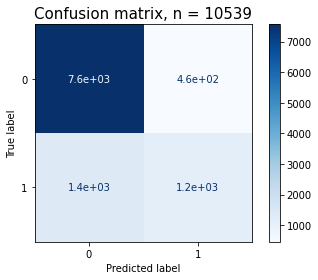

In [53]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()


Q. 임계값을 증가시킬때 positive 범주에 대한 재현율의 변화 양상을 과제 제출폼에 제출하세요.
- 감소한다



### 3) 랜덤포레스트의 n_estimator를 1, 10, 100, 1000으로 바꾸어 가며 positive 범주의 predict_proba를 비교해 보세요
- 파라미터는 다음과 같이 설정합니다.
    - n_jobs=-1, random_state=10, max_depth=None, n_estimators = n
- **(객관식) 확률값들의 분포(종류)의 변화를 과제 제출폼에 제출하세요**
    1. 다양해진다
    2. 변화가없다


다양해진다
n_estimators: 생성할 트리의 개수를 지정한다.
n_estimators의 변수를 변경할 경우, 만드는 트리의 수가 달라져서 더 세밀한 예측이 가능해진다.

In [ ]:
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [ ]:
nostate = train.drop(['vacc_h1n1_f','state'], axis=1).columns

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


n_estimators: 1

훈련 정확도:  0.8477305076704096
검증 정확도:  0.7556694183508872
검증 f1:  0.4696189495365603


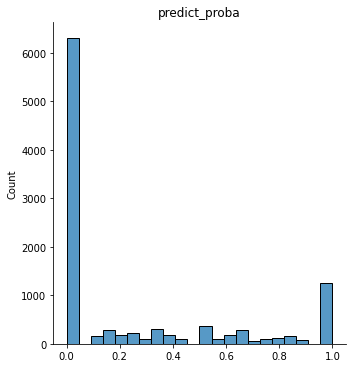

------------------------------------ 



/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


n_estimators: 10

훈련 정확도:  0.9238336232800886
검증 정확도:  0.8193376980738211
검증 f1:  0.5528417097228747


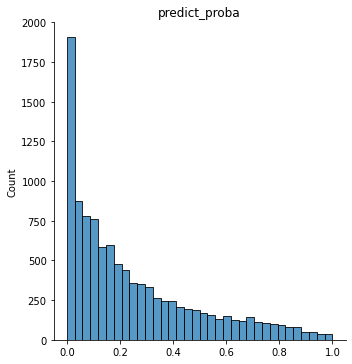

------------------------------------ 



/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


n_estimators: 100

훈련 정확도:  0.9338605092519374
검증 정확도:  0.8288262643514565
검증 f1:  0.562772661173049


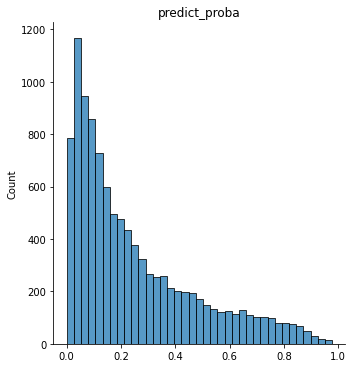

------------------------------------ 



/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


n_estimators: 1000

훈련 정확도:  0.9350308397912384
검증 정확도:  0.829205807002562
검증 f1:  0.5645863570391872


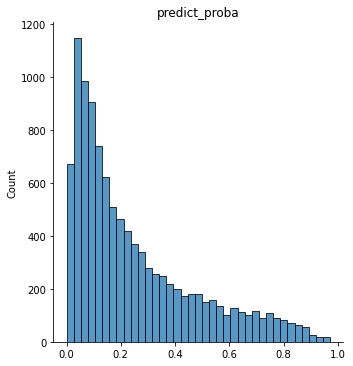

------------------------------------ 



In [54]:
#pipe
onehot= ["employment_status"]
ordinals = ['opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_h1n1_sick_from_vacc', "agegrp"]

num = [1,10,100,1000]
for i in num:
  pipe = make_pipeline(
      OneHotEncoder(use_cat_names=True, cols=onehot), 
      OrdinalEncoder(cols=ordinals), 
      SimpleImputer(), 
      RandomForestClassifier(n_estimators=i, random_state=10, n_jobs=-1,min_samples_split = 6)
     # n_estimators: 생성할 트리 갯수 (바꿔가면서 과제진행)
  )
  pipe.fit(X_train, y_train)

  print('n_estimators:', i)
  # 모델 정확도
  print('\n훈련 정확도: ', pipe.score(X_train, y_train))
  print('검증 정확도: ', pipe.score(X_val, y_val))
  # f1 score
  y_pred = pipe.predict(X_val)
  print('검증 f1: ', f1_score(y_val, y_pred))
  # 확률값 분포
  y_pred_proba = pipe.predict_proba(X_val)[:, 1]
  sns.displot(y_pred_proba)
  plt.title("predict_proba")
  plt.show()
  print('------------------------------------ \n')

### 4) 두개 이상의 다른 분류 모델을 학습시켜 ROC curve, AUC 점수를 비교하고 설명합니다.
- 더 좋은 결과가 나오는 모델을 사용해서 캐글에 제출하세요
- **캐글 Leaderboard의 본인 Score를 과제 제출폼에 제출하세요.**

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


auc_score_1: 0.7053482312480015


Text(0, 0.5, 'TPR(Recall)')

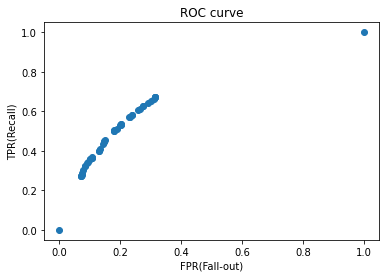

In [70]:
# modeling RandomForest
from sklearn.metrics import roc_curve, roc_auc_score
onehot= ["employment_status"]
ordinals = ['opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_h1n1_sick_from_vacc', "agegrp"]

pipe_1 = make_pipeline(
    OneHotEncoder(use_cat_names=True, cols=onehot), 
    OrdinalEncoder(cols=ordinals), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=1, random_state=10, n_jobs=-1,min_samples_split = 6)
)

pipe_1.fit(X_train, y_train)

# AUC 점수
y_pred_proba_1 = pipe_1.predict_proba(X_val)[:, 1]
auc_score_1 = roc_auc_score(y_val, y_pred_proba_1)
print('auc_score_1:', auc_score_1)

# ROC curve
fpr_1, tpr_1, thresholds_1 = roc_curve(y_val, y_pred_proba_1)

roc_1 = pd.DataFrame({'FPR(Fall-out)': fpr_1, 
                      'TPRate(Recall)': tpr_1, 
                      'Threshold': thresholds_1
})

plt.scatter(fpr_1, tpr_1)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


auc_score_1000: 0.8345657046348005


Text(0, 0.5, 'TPR(Recall)')

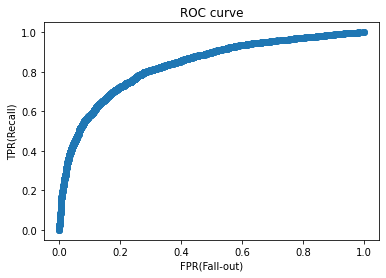

In [69]:
# modeling RandomForest
from sklearn.metrics import roc_curve, roc_auc_score
onehot= ["employment_status"]
ordinals = ['opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_h1n1_sick_from_vacc', "agegrp"]

pipe_1000 = make_pipeline(
    OneHotEncoder(use_cat_names=True, cols=onehot), 
    OrdinalEncoder(cols=ordinals), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=1000, random_state=10, n_jobs=-1,min_samples_split = 6)
)

pipe_1000.fit(X_train, y_train)

# AUC 점수
y_pred_proba_1000 = pipe_1000.predict_proba(X_val)[:, 1]
auc_score_1000 = roc_auc_score(y_val, y_pred_proba_1000)
print('auc_score_1000:', auc_score_1000)

# ROC curve
fpr_1000, tpr_1000, thresholds_1000 = roc_curve(y_val, y_pred_proba_1000)

roc_1000 = pd.DataFrame({'FPR(Fall-out)': fpr_1000, 
                      'TPRate(Recall)': tpr_1000, 
                      'Threshold': thresholds_1000
})

plt.scatter(fpr_1000, tpr_1000)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')

In [71]:
y_pred_proba_1000 = pipe_1000.predict_proba(X_test)[:, 1]
y_pred_1000 = y_pred_proba_1000 > 0.3
from sklearn.metrics import f1_score
print('f1_score:', f1_score(sample_submission['vacc_h1n1_f'], y_pred_1000))

f1_score: 0.37828293974839994


In [73]:
id = sample_submission['Id'].values
submission = pd.DataFrame({'Id': id, 'vacc_h1n1_f': y_pred_1000})
submission.to_csv('submission_h1n1_EM0.csv', index=False)

## 🔥 도전과제

### 5) 각 평가지표에 대해 결과를 최대한 분석하고 무엇이 부족한지, 어떤 방향으로 성능을 높여야 하는지 논하세요.

In [ ]:
### 이곳에서 과제를 진행해 주세요 ### 